Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [3]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [4]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [5]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [6]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [8]:
df['Date'] = pd.to_datetime(df['Date'])
print(df.dtypes)
print(df.shape)
df.head()

Burrito                   object
Date              datetime64[ns]
Yelp                     float64
Google                   float64
Chips                     object
Cost                     float64
Hunger                   float64
Mass (g)                 float64
Density (g/mL)           float64
Length                   float64
Circum                   float64
Volume                   float64
Tortilla                 float64
Temp                     float64
Meat                     float64
Fillings                 float64
Meat:filling             float64
Uniformity               float64
Salsa                    float64
Synergy                  float64
Wrap                     float64
Unreliable                object
NonSD                     object
Beef                      object
Pico                      object
Guac                      object
Cheese                    object
Fries                     object
Sour cream                object
Pork                      object
Chicken   

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,...,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,2016-01-24,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,2016-01-27,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


1- Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
2- Begin with baselines for classification.
3- Use scikit-learn for logistic regression.
4- Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
5- Get your model's test accuracy. (One time, at the end.)

In [27]:
#Split into train/validate/test
train = df[df['Date'] <= '2016-12-31'] 
val = df[df['Date'] <= '2017-12-31']
val = val[val['Date'] >= '2017-01-01']
test = df[df['Date'] >= '2018-01-01']
print(train.shape)
print(val.shape)
print(test.shape)

(298, 59)
(85, 59)
(38, 59)


Note to self- I'm concerned that the target isn't a number. So, I'm going to change False to 0 and True to 1. This might be entirely not needed, but I'm doing it for my comfort.

In [32]:
train['Great'] = train['Great'].astype(int)
#train['Great'] = train['Great'].replace({'True':1})
val['Great'] = val['Great'].astype(int)
#val['Great'] = val['Great'].replace({'True':1})
test['Great'] = test['Great'].astype(int)
#test['Great'] = test['Great'].replace({'True': 1})
train.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,...,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Carnitas,2016-01-24,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Asada,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,California,2016-01-27,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [33]:
#Baselines for classification.
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

0    0.590604
1    0.409396
Name: Great, dtype: float64

In [34]:
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)
y_pred[:5]

[0, 0, 0, 0, 0]

In [35]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred)

0.5906040268456376

In [36]:
y_val = val[target]
y_pred = [majority_class] * len(y_val)
accuracy_score(y_val, y_pred)

0.5529411764705883

Alright, so it looks like the baseline for my train set is a 59% chance of *not* having a Great score, while the validation has a 55% chance of *not* having a Great score.

In [40]:
#3- Use scikit-learn for logistic regression. Before we can do that, we should pick some features. 
# OneHotEncoding is a stretch goal, so lets just focus on the numerical values for now. 
#There are a bunch of categorical values, so there might be some room for improvement.
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
features = ['Meat', 'Mass (g)', 'Fillings']
X_train = train[features]
X_val = val[features]
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train_imputed, y_train)


LogisticRegression()

In [41]:
#4- Get your model's test accuracy 
print('Validation Acccuracy', log_reg.score(X_val_imputed, y_val))

Validation Acccuracy 0.8941176470588236


Alright, so it looks like my test model has an accuracy of close to 90%, which is pretty good. I'm going to give this another shot by seeing if adding another feature can raise this to past 90%.

In [60]:
feature1 = ['Meat', 'Fillings', 'Hunger']
X_train1 = train[feature1]
X_val1 = val[feature1]
X_train1_imputed = imputer.fit_transform(X_train1)
X_val1_imputed = imputer.transform(X_val1)
log_reg.fit(X_train1_imputed, y_train)
print('Validation Accuracy, mach2-', log_reg.score(X_val1_imputed, y_val))

Validation Accuracy, mach2- 0.9058823529411765


In [61]:
#5- Test your test data to see how well I predict stuff...
#from sklearn.linear_model import LogisticRegressionCV
model = LogisticRegression()
X_test = test[feature1]
y_test = test[target]
X_test_imputed = imputer.fit_transform(X_test)
model.fit(X_test_imputed, y_test)
y_pred = model.predict(X_test_imputed)
print('Validation Accuracy of Test Data:', model.score(X_test_imputed, y_test))

Validation Accuracy of Test Data: 0.7368421052631579


In [63]:
print('Validation Accuracy of Test Data:', log_reg.score(X_test_imputed, y_test))

Validation Accuracy of Test Data: 0.6578947368421053


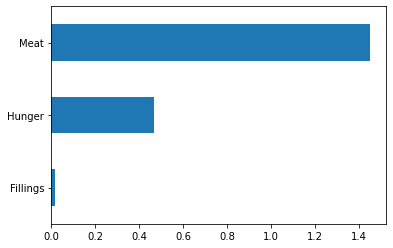

In [62]:
import matplotlib
%matplotlib inline
coefficients = pd.Series(model.coef_[0], X_test.columns)
coefficients.sort_values().plot.barh();